# ANLP Assignment (Autumn 2020)

For assessment, you are expected to complete and submit this notebook file. When answers require code, you may import and use library functions (unless explicitly told otherwise). All of your own code should be included in the notebook rather than imported from elsewhere. Written answers should also be included in the notebook. You should insert as many extra cells as you want and change the type between code and markdown as appropriate.

In order to avoid misconduct, you should not talk about the assignment questions with your peers. If you are not sure what a question is asking you to do or have any other questions, please ask me or one of the Teaching Assistants.

Marking guidelines are provided as a separate document.

The first few cells contain code to set-up the assignment and bring in some data. In order to provide unique datasets for analysis by different students, you must enter your candidate number in the following cell. Otherwise do not change the code in these cells.

In [58]:
candidateno = 253251 #this MUST be updated to your candidate number so that you get a unique data sample

In [59]:
#set up drives for resources.  Change the path as necessary

from google.colab import drive
#mount google drive
drive.mount('/content/drive/', force_remount=True)
import sys
sys.path.append('/content/drive/My Drive/ANLP_Assignment/resources/')


Mounted at /content/drive/


In [60]:
#do not change the code in this cell
#preliminary imports

import re
import random
import math
import pandas as pd
import matplotlib.pyplot as plt
from itertools import zip_longest

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('wordnet_ic')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet_ic as wn_ic
brown_ic = wn_ic.ic("ic-brown.dat")

from sussex_nltk.corpus_readers import AmazonReviewCorpusReader
from sussex_nltk.corpus_readers import ReutersCorpusReader

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet_ic to /root/nltk_data...
[nltk_data]   Package wordnet_ic is already up-to-date!


# Question 1: Books vs DVDs

In this question, you will be investigating NLP methods for distinguishing reviews written about books from reviews written about DVDs.

In [61]:
#do not change the code in this cell
def split_data(data, ratio=0.7): # when the second argument is not given, it defaults to 0.7
    """
    Given corpus generator and ratio:
     - partitions the corpus into training data and test data, where the proportion in train is ratio,

    :param data: A corpus generator.
    :param ratio: The proportion of training documents (default 0.7)
    :return: a pair (tuple) of lists where the first element of the 
            pair is a list of the training data and the second is a list of the test data.
    """
    
    data = list(data)  
    n = len(data)  
    train_indices = random.sample(range(n), int(n * ratio))          
    test_indices = list(set(range(n)) - set(train_indices))    
    train = [data[i] for i in train_indices]           
    test = [data[i] for i in test_indices]             
    return (train, test)                       
 

def feature_extract(review):
    """
    Generate a feature representation for a review
    :param review: AmazonReview object
    :return: dictionary of Boolean features
    """
    return {word:True for word in review.words()}

def get_training_test_data(categories=('book','dvd'),ratio=0.7,seed=candidateno):
    """
    Get training and test data for a given pair of categories and ratio, pre-formatted for use with NB classifier
    :param category: pair of categories of review corpus, two from ["kitchen, "dvd, "book", "electronics"]
    :param ratio: proportion of data to use as training data
    :return: pair of lists 
    """
    random.seed(candidateno)

    train_data=[]
    test_data=[]
    for category in categories:
      reader=AmazonReviewCorpusReader().category(category)    
      train, test = split_data(reader.documents(),ratio=ratio)
   
      train_data+=[(feature_extract(review),category)for review in train]
      test_data+=[(feature_extract(review),category)for review in test]
    random.shuffle(train_data)
    random.shuffle(test_data)

    return train_data,test_data

When you have run the cell below, your unique training and testing samples will be stored in `training_data` and `testing_data`

In [62]:
#do not change the code in this cell
training_data,testing_data=get_training_test_data()
print("The amount of training data is {}".format(len(training_data)))
print("The amount of testing data is {}".format(len(testing_data)))
print("The representation of a single data item is below")
print(training_data[0])

The amount of training data is 6526
The amount of testing data is 2799
The representation of a single data item is below
({'Even': True, 'the': True, 'avid': True, '``': True, 'trekie': True, 'reader': True, 'of': True, 'Star': True, 'Trek': True, 'science': True, 'fiction': True, 'novels': True, ',': True, 'movies': True, 'and': True, 'television': True, 'series': True, 'must': True, 'suspend': True, 'disbelief': True, 'when': True, 'he': True, 'finds': True, 'Captain': True, 'Kirk': True, 'saying': True, 'Beam': True, 'me': True, 'up': True, 'Scotty': True, '.': True, 'But': True, 'biblical': True, 'literalist': True, 'reading': True, 'this': True, 'book': True, 'need': True, 'make': True, 'no': True, 'such': True, 'effort': True, 'reads': True, 'in': True, 'that': True, 'Jesus': True, 'will': True, 'effectively': True, 'beam': True, 'millions': True, 'true': True, 'Christians': True, 'to': True, 'heaven': True, 'world-wide': True, 'Rapture': True, 'Though': True, 'characters': True,

a) Use your training data to find
i) the top 20 words which occur more frequently in book reviews than in dvd reviews
ii) the top 20 words which occur more frequently in dvd reviews than book reviews
Discuss what pre-processing techniques you have applied (or not applied) in answering this question, and why. [10 marks]

First, in the preprocessing phase, I normalized numbers, case, and unimportant tokens. Because numbers, uppercase and lowercase are natural language processing for us, we just need to know that numbers are numbers. After that, I deleted the stop word because it is the most common word in English articles. If we take this into account, it will greatly affect our judgment of the important words in the article. Finally, I used stemming to extract the stemmer, which makes the word simpler.

In [63]:
def pre_processing(data):
  """
  pre_processing the documents include:
  word Tokenisation(this has already done by the upping)
  Noramalisation(case, number, stopwords and punctuation)
  Stemming/ lemmatisation
  :param data_list: the data which needs to be preprocessed.
  :return: preprocess_doc
  """
  def normalise(data_list):
    # Normalising text and removing unimportant tokens
    normalised = [str(token) if type(token) == int else token for token in data_list]
    # Case normalisation 
    normalised = [token.lower() for token in data_list]
    # Replace all number tokens with "NUM" in a new list of tokens
    normalised = ["NUM" if token.isdigit() else token for token in data_list]  
    normalised = ["Nth" if (token.endswith(("nd","st","th")) and token[:-2].isdigit()) else token for token in data_list]
    normalised = ["NUM" if re.search("^[+-]?[0-9]+\.[0-9]",token) else token for token in data_list]
    return normalised

  def stop_words_removal(data_list):
    # Punctuation and Stopword removal
    normalised = [token for token in data_list if token not in stopwords.words('english') and token.isalpha()]
    return normalised

  def stem(data_list):
    st = PorterStemmer()
    stemming_data = [st.stem(token) for token in data_list]
    return stemming_data

 # 
  pre_process = [(stem(stop_words_removal(normalise(list(token.keys())))), label) for token,label in data]
  pre_process = [({word:True for word in token}, label) for token,label in pre_process]

  return pre_process

In [64]:
# pre-processing with training and testing data
pre_train = pre_processing(training_data)
pre_test =  pre_processing(testing_data)

In [65]:
def get_labels(data):
  """
  get the labels from the data
  :param data: the data which needs to be gotten its' labels
  :return: lables with list
  """
  labels = []
  for token,label in data:
    if label not in labels:
      labels.append(label)
  return labels

labels = get_labels(pre_train)
labels

['book', 'dvd']

In [66]:
from collections import Counter
def most_frequent_words(data_list, n):
  """
  find top n most frequent words in the datalist
  This function takes 2 arguments:
  :param: a data_set with list dataframe, top n common words
  :return:
  """
  book_freq = {}
  dvd_freq = {}
  for (token, label) in data_list:
    if label == 'book':
      for word in token.keys():
          book_freq[word] = book_freq.get(word,0) + 1
    
    elif label == 'dvd':
      for word in token.keys():
          dvd_freq[word] = dvd_freq.get(word,0) + 1
  
  book = dict(Counter(book_freq)-Counter(dvd_freq))
  book = sorted(book.items(), key = lambda kv:(kv[1], kv[0]), reverse=True)[:n]

  dvd = dict(Counter(dvd_freq)-Counter(book_freq))
  dvd = sorted(dvd.items(), key = lambda kv:(kv[1], kv[0]), reverse=True)[:n]
  
  return book, dvd

In [67]:
book_freq, dvd_freq = most_frequent_words(pre_processing(pre_train), 20)
book_freq

[('book', 1954),
 ('read', 1113),
 ('author', 468),
 ('reader', 335),
 ('write', 321),
 ('page', 299),
 ('written', 243),
 ('inform', 201),
 ('novel', 195),
 ('chapter', 157),
 ('detail', 102),
 ('exampl', 101),
 ('publish', 100),
 ('research', 99),
 ('use', 88),
 ('writer', 83),
 ('descript', 83),
 ('cover', 80),
 ('refer', 79),
 ('text', 77)]

In [68]:
dvd_freq

[('movi', 1827),
 ('film', 1310),
 ('watch', 1075),
 ('dvd', 1028),
 ('see', 630),
 ('one', 611),
 ('great', 560),
 ('scene', 548),
 ('like', 541),
 ('show', 504),
 ('love', 501),
 ('play', 487),
 ('get', 475),
 ('good', 451),
 ('act', 439),
 ('seen', 434),
 ('actor', 396),
 ('thi', 390),
 ('music', 379),
 ('perform', 374)]

b) Design, build and test a word list classifier to classify reviews as being from the book domain or from the dvd domain.  Make sure you discuss i) how you decide the lengths and contents of the word lists and ii) accuracy, precision and recall of your final classifier.[15 marks]

First, SimpleClassifer will be rated according to the label of words in the text, which is one for the most frequent meetings of'book'and one for none. They are then classified according to positive and negative pairs. In finding the best k, I used range (1, 20, 2) to search for the best K value.

In [69]:
from nltk.classify.api import ClassifierI
import random

class SimpleClassifier(ClassifierI): 
  """
  Used as the data_list for creating a word list based classifier.
  """
  def __init__(self):
    """
    Initilalise the parameters 
    """
    self.labels = ['book', 'dvd']

  def classify(self, words): 
    """
    Create a classify using to classify the label 
    """
    score = 0
    for word in words:
      if word in self.book_freq:
        score += 1
      elif word in self.dvd_freq:
        score -= 1
    
    if score > 0:
      return self.labels[0] # return 'book' labels
    elif score < 0:
      return self.labels[1] #return 'dvd' labels
    else:
      return random.choice(self.labels)
  
  def train(self, data_list, n):
    """
    :param:data_list for traning the classifier, n for the top n frequent words.
    return None
    """
    book_freq = {}
    dvd_freq = {}
    for (token, label) in data_list:
      if label == 'book':
        for word in token.keys():
            book_freq[word] = book_freq.get(word,0) + 1
      
      elif label == 'dvd':
        for word in token.keys():
            dvd_freq[word] = dvd_freq.get(word,0) + 1
    
    book = dict(Counter(book_freq)-Counter(dvd_freq))
    book = sorted(book.items(), key = lambda kv:(kv[1], kv[0]), reverse=True)[:n]
    self.book_freq = [word for word,freq in book]
    

    dvd = dict(Counter(dvd_freq)-Counter(book_freq))
    dvd = sorted(dvd.items(), key = lambda kv:(kv[1], kv[0]), reverse=True)[:n]
    self.dvd_freq = [word for word,freq in dvd]

In [70]:
def get_labels(data):
  """
  Get the testing label so that we can calculate the indexes 
  :param: testing_data based on a list
  :return: a list with label
  """
  return [label for doc,label in data]

# Get the testing labels
test_labels = get_labels(pre_test)
pre_train = pre_processing(pre_train)

In [71]:
def evaluate_classifer(prediction, test_label):
  """
  evaluate the performance of classifier
  :param: prediction, test_label
  :return: accurary, precision, recall, f1_score
  """
  tp = 0
  fn = 0
  fp = 0
  tn = 0

  for pred, act in zip(prediction, test_label):
    if act == 'book':
      if pred == 'book':
        tp += 1
      else:
        fn += 1
    
    elif pred == 'book':
      fp += 1
    else:
      tn += 1
    
  accurary = (tp+tn)/(tp+fp+tn+fn)
  precision = tp / (tp+fp)
  recall = tp / (tp+fn)
  f1_score = ( 2/( 1/precision + 1/recall ))

  return round(accurary,2), round(precision,2), round(recall,2), round(f1_score,2)

In [72]:
def get_best_k(pre_train, pre_test):
  """
  Get the best k for simple classifier
  :param: trainlist, testlist
  :return: k_best, accuracy, precision, recall, f1_score
  """
  sc = SimpleClassifier()
  k_stored = {}
  test_label = get_labels(pre_test)
  for k in range(1, 20, 2):
    sc.train(pre_train, k)
    predictions_sc = [sc.classify(doc) for doc,label in pre_test]
    Accuracy= evaluate_classifer(predictions_sc, test_label)[0]
    k_stored[k] = Accuracy
    # print("k =", k, ",Accuracy =", Accuracy, ",F1_Score =", F1_Score, 
    #       ",Precision =",Precision, ",Recall =", Recall)
  k_best =  max(k_stored.items(),key=lambda x:x[1])[0]
  # print("best_k is",k_best[0])
  sc.train(pre_train, k_best)
  predictions_sc = [sc.classify(doc) for doc,label in pre_test]
  Accuracy, Precision, Recall, F1_Score= evaluate_classifer(predictions_sc, test_label)
  return  k_best, Accuracy, Precision, Recall, F1_Score

k_best, sc_accuracy, sc_precision, sc_recall, sc_f1 =get_best_k(pre_train, pre_test )
print("best k =", k_best, ",Accuracy =", sc_accuracy, ",F1_Score =", sc_f1, 
      ",Precision =",sc_precision, ",Recall =", sc_recall)

def get_best_metrics(pre_train, pre_test):
  k, Accuracy, Precision, Recall, F1_Score = get_best_k(pre_train, pre_test)
  metrics = [Accuracy, Precision, Recall, F1_Score]
  return k, metrics

def get_metrics(prediction, test_label):
  accurary, precision, recall, f1_score = evaluate_classifer(prediction, test_label)
  metrics = [accurary, precision, recall, f1_score]
  return metrics

best k = 5 ,Accuracy = 0.91 ,F1_Score = 0.89 ,Precision = 0.87 ,Recall = 0.92


c) Compare the performance of your word list classifier with a Naive Bayes classifier (e.g., from NLTK).  Make sure you discuss the results. [10 marks]

Accuracy = 0.93 ,F1_Score = 0.92 ,Precision = 0.92 ,Recall = 0.91


,0,1
0,Simple,0.91
1,NaiveBayes,0.93


(0.0, 1.0)

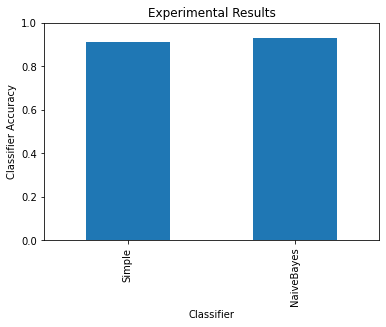

In [73]:
from nltk import NaiveBayesClassifier
myclassifier_train = NaiveBayesClassifier.train(pre_train)

predictions_test_nb = [myclassifier_train.classify(doc) for doc,label in pre_test]

Accuracy, Precision, Recall, F1_Score= evaluate_classifer(predictions_test_nb, test_labels)
print( "Accuracy =", Accuracy, ",F1_Score =", F1_Score, 
        ",Precision =",Precision, ",Recall =", Recall)

results = []
results.append(('Simple', sc_accuracy))
results.append(('NaiveBayes', Accuracy))

df = pd.DataFrame(results)
display(df)
ax = df.plot.bar(title="Experimental Results",legend=False,x=0)
ax.set_ylabel("Classifier Accuracy")
ax.set_xlabel("Classifier")
ax.set_ylim(0,1.0)

Overall, Naive Bayesian classification works better than Simple Classifier with best K value because Naive Bayesian calculates the frequency of each class in training samples and estimates the conditional probability of each class for each feature attribute classification, and records the results.

d) Design and carry out an experiment into the impact of the amount of training data on each of these classifiers.  Make sure you describe design decisions in your experiment, include a graph of your results and discuss your conclusions. [15 marks] 

In [74]:
from random import sample

def sample_test(pre_train, pre_test, sizes):
  simple_metrics = []
  naive_metrics = []
  best_k = []
  sc = SimpleClassifier()
  test_labels = get_labels(pre_test)

  for n in sizes:
    train = sample(pre_train, n)
    k, sc_metrics = get_best_metrics(train, pre_test)
    best_k.append(k)
    simple_metrics.append(sc_metrics)

    myclassifier_train = NaiveBayesClassifier.train(train)
    predictions_test_nb = [myclassifier_train.classify(doc) for doc,label in pre_test]
    naive_metrics.append(get_metrics(predictions_test_nb, test_labels))

  return best_k, simple_metrics, naive_metrics


In [75]:
import numpy as np
sample_sizes = list(map(int, np.linspace(100, len(pre_train), 60)))
k_best, sc_met, nbc_met = sample_test(pre_train, pre_test, sample_sizes)

In [76]:
print(k_best)
print(sc_met)
print(nbc_met)

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
[[0.88, 0.82, 0.9, 0.86], [0.9, 0.86, 0.91, 0.88], [0.9, 0.86, 0.91, 0.89], [0.9, 0.87, 0.88, 0.88], [0.91, 0.87, 0.92, 0.9], [0.9, 0.86, 0.9, 0.88], [0.91, 0.86, 0.94, 0.9], [0.91, 0.89, 0.89, 0.89], [0.91, 0.87, 0.93, 0.9], [0.91, 0.87, 0.92, 0.9], [0.91, 0.9, 0.87, 0.89], [0.91, 0.86, 0.94, 0.9], [0.92, 0.87, 0.93, 0.9], [0.92, 0.88, 0.93, 0.9], [0.91, 0.87, 0.93, 0.9], [0.92, 0.87, 0.94, 0.9], [0.9, 0.86, 0.9, 0.88], [0.9, 0.88, 0.88, 0.88], [0.91, 0.86, 0.93, 0.9], [0.9, 0.89, 0.87, 0.88], [0.91, 0.9, 0.88, 0.89], [0.91, 0.89, 0.89, 0.89], [0.91, 0.87, 0.93, 0.9], [0.9, 0.88, 0.87, 0.88], [0.92, 0.88, 0.92, 0.9], [0.91, 0.87, 0.93, 0.9], [0.9, 0.88, 0.88, 0.88], [0.91, 0.87, 0.93, 0.9], [0.9, 0.88, 0.88, 0.88], [0.92, 0.88, 0.93, 0.9], [0.92, 0.87, 0.93, 0.9], [0.91, 0.89, 0.89, 0.89], [0.9, 0.89, 0.88,

,Sample,Best k,Accuracy SC,Precision SC,Recall SC,F1 SC,Accuracy NBC,Precision NBC,Recall NBC,F1 NBC
0,100,5,0.88,0.82,0.90,0.86,0.85,0.78,0.89,0.83
1,208,5,0.90,0.86,0.91,0.88,0.83,0.72,0.96,0.82
2,317,5,0.90,0.86,0.91,0.89,0.88,0.80,0.95,0.87
3,426,5,0.90,0.87,0.88,0.88,0.91,0.88,0.91,0.90
4,535,5,0.91,0.87,0.92,0.90,0.88,0.80,0.95,0.87
5,644,5,0.90,0.86,0.90,0.88,0.87,0.78,0.96,0.86
6,753,5,0.91,0.86,0.94,0.90,0.89,0.96,0.77,0.85
7,862,5,0.91,0.89,0.89,0.89,0.89,0.94,0.80,0.86
8,971,5,0.91,0.87,0.93,0.90,0.91,0.85,0.94,0.89
9,1080,5,0.91,0.87,0.92,0.90,0.92,0.88,0.93,0.91


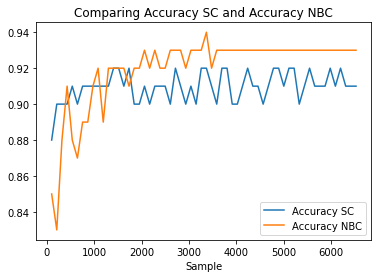

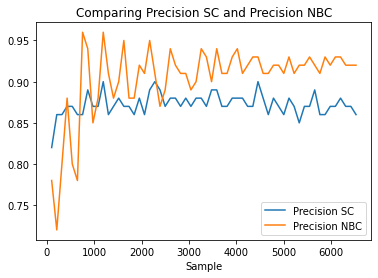

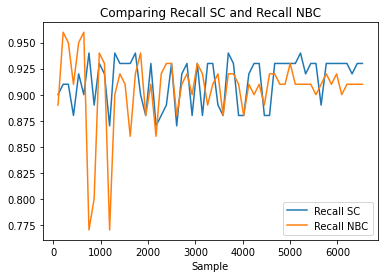

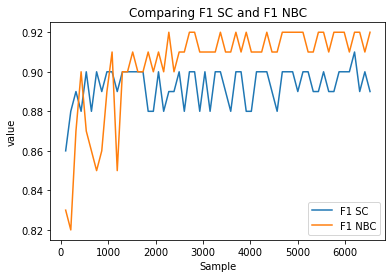

In [77]:
results1 = [[x]+y+z for x,y,z in zip(k_best, sc_met, nbc_met)] 
results2 = [[x]+y for x,y in zip(sample_sizes, results1)]

cols = ["Sample", "Best k", "Accuracy SC","Precision SC","Recall SC",
        "F1 SC", "Accuracy NBC", "Precision NBC", "Recall NBC","F1 NBC"]

df = pd.DataFrame(results2,columns = cols)
display(df)

for ind in range(2, len(cols) - 4):
  ax = df.plot(kind='line',x = 'Sample',y=[cols[ind], cols[ind + 4]],
               title="Comparing " + cols[ind] + " and " + cols[ind + 4])
ax.set_ylabel("value")
ax.legend(loc='best')
plt.show()

Overall, Naive Bayesian classification works better than Simple Classifier with best K value because Naive Bayesian calculates the frequency of each class in training samples and estimates the conditional probability of each class for each feature attribute classification, and records the results. SimpleClassifier is more advantageous when the number of samples is low, because Naive Bayesian needs to be estimated by probability.

# Question 2: Distributional Semantics

In this question, you will be investigating the *distributional hypothesis*: **words which appear in similar contexts tend to have similar meanings**.

We are going to be using the Reuters corpus of financial documents for this part of the assignment.  When you run the following cell you should see that it contains 1,113,359 sentences.

In [78]:
#do not change the code in this cell
rcr = ReutersCorpusReader().finance()
rcr.enumerate_sents()

1113359

The following cell will take 2-5 minutes to run.  It will generate a unique-to-you sample of 200,000 sentences.  These sentences are tokenised and normalised for case and number for you.

In [79]:
#do not change the code in this cell
def normalise(tokenlist):
    tokenlist=[token.lower() for token in tokenlist]
    tokenlist=["NUM" if token.isdigit() else token for token in tokenlist]
    tokenlist=["Nth" if (token.endswith(("nd","st","th")) and token[:-2].isdigit()) else token for token in tokenlist]
    tokenlist=["NUM" if re.search("^[+-]?[0-9]+\.[0-9]",token) else token for token in tokenlist]
    return tokenlist

random.seed(candidateno)  
samplesize=2000
iterations =100
sentences=[]
for i in range(0,iterations):
    sentences+=[normalise(sent) for sent in rcr.sample_sents(samplesize=samplesize)]
    print("Completed {}%".format(i))
print("Completed 100%")


Completed 0%
Completed 1%
Completed 2%
Completed 3%
Completed 4%
Completed 5%
Completed 6%
Completed 7%
Completed 8%
Completed 9%
Completed 10%
Completed 11%
Completed 12%
Completed 13%
Completed 14%
Completed 15%
Completed 16%
Completed 17%
Completed 18%
Completed 19%
Completed 20%
Completed 21%
Completed 22%
Completed 23%
Completed 24%
Completed 25%
Completed 26%
Completed 27%
Completed 28%
Completed 29%
Completed 30%
Completed 31%
Completed 32%
Completed 33%
Completed 34%
Completed 35%
Completed 36%
Completed 37%
Completed 38%
Completed 39%
Completed 40%
Completed 41%
Completed 42%
Completed 43%
Completed 44%
Completed 45%
Completed 46%
Completed 47%
Completed 48%
Completed 49%
Completed 50%
Completed 51%
Completed 52%
Completed 53%
Completed 54%
Completed 55%
Completed 56%
Completed 57%
Completed 58%
Completed 59%
Completed 60%
Completed 61%
Completed 62%
Completed 63%
Completed 64%
Completed 65%
Completed 66%
Completed 67%
Completed 68%
Completed 69%
Completed 70%
Completed 71%
Co

`generate_features()` will used and explored below.

In [80]:
# do not change the code in this cell
def generate_features(sentences,window=1):
    mydict={}
    for sentence in sentences:
        for i,token in enumerate(sentence):
            current=mydict.get(token,{})
            features=sentence[max(0,i-window):i]+sentence[i+1:i+window+1]
            for feature in features:
                current[feature]=current.get(feature,0)+1
            mydict[token]=current
    return mydict

a) Run `generate_features(sentences[:5])`. With reference to the code and the specific examples, explain how the output was generated [5 marks]

In [81]:
generate_features(sentences[:5])

{'(': {'june': 1, 'ministry': 1},
 ')': {'NUM': 1},
 '+5017': {'-': 1, 'fax': 1},
 ',': {'all': 1, 'industry': 1, 'issue': 1, 'which': 1},
 '-': {'+5017': 1, 'reuters': 1, 'www.racs.com': 1},
 '.': {'abroad': 1, 'airbus': 1, 'pakistan': 1},
 '=': {'f.min': 1, 'finance': 1},
 'NUM': {')': 1, 'NUM': 6, 'fax': 1, 'june': 1, 'tel+': 1},
 'a': {'is': 1, 'trade': 1},
 'able': {'be': 1, 'to': 1},
 'about': {'all': 1, 'protecting': 1},
 'abroad': {'.': 1, 'skepticism': 1},
 'ahead': {'in': 1, 'was': 1},
 'air': {'cargo': 1, 'reuters': 1},
 'airbus': {'.': 1, 'protecting': 1},
 'all': {',': 1, 'about': 1},
 'and': {'had': 1, 'prices': 1, 'quality': 1, 'research': 1},
 'at': {'particularly': 1, 'risk': 1},
 'be': {'able': 1, 'not': 1},
 'because': {'goods': 1, 'india': 1},
 'been': {'greeted': 1, 'has': 1},
 'but': {'the': 1},
 'cargo': {'air': 1, 'service': 1},
 'compete': {'to': 1, 'with': 1},
 'costs': {'production': 1, 'than': 1},
 'engineering': {'industry': 1, 'the': 1},
 'f.min': {'=': 1}

*   First, 'generate_ Features' takes two parameters, one is Sentence and the other 
is Window. Create a dictionary'mydict'inside the function to store token and its feature values in the context. 
*   Second, use an enumeration loop to access the contents of each sentence, store an empty dictionary with'current'for each new token, and add the features of the current token. 
*   Then, all the features are iterated through and added to the current token's dictionary. 
*   Finally, the current token is added to mydict's keys to ensure that each word is constantly updated in the sentence after it is created.
*   When sentences [:5] is run, the first five sentences of sentences are viewed. 

b) Write code and **find** the 1000 most frequently occurring words that
* are in your sample; AND
* have at least one noun sense according to WordNet [5 marks]

In [82]:
import nltk
nltk.download('omw-1.4')
from nltk.corpus import wordnet as wn
from nltk import FreqDist
from nltk import pos_tag

def find_frequent_words(sentencelist, tag, k):
  """
  find the top k sentences by using the tag
  word have at least one noun sense according to WordNet
  :param: a word list, tag by using WordNet, number k
  :return: top k frequent words
  """
  pos = {'NOUN':wn.NOUN, 'VERB':wn.VERB, 'ADJ':wn.ADJ, 'ADV':wn.ADV}
  freq = [] #Save word and subsequent frequency statistics
  for sentence in sentencelist:
    for word in sentence:
      if wn.synsets(word, pos=pos[tag]):
        freq.append(word)

  fdist = FreqDist(freq)
  
  return fdist.most_common(k)

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [83]:
freq_words = find_frequent_words(sentences, 'NOUN', 1000)

In [84]:
# do not change the code in this cell.  It relates to part c)
wordpair=("house","garden")
concept_1=wn.synsets(wordpair[0])[0]
concept_2=wn.synsets(wordpair[1])[0]
print("Path similarity between 1st sense of {} and 1st sense of {} is {}".format(wordpair[0],wordpair[1],wn.path_similarity(concept_1,concept_2)))
print("Resnik similarity between 1st sense of {} and 1st sense of {} is {}".format(wordpair[0],wordpair[1],wn.res_similarity(concept_1,concept_2, brown_ic)))
print("Lin similarity between 1st sense of {} and 1st sense of {} is {}".format(wordpair[0],wordpair[1],wn.lin_similarity(concept_1,concept_2, brown_ic)))

Path similarity between 1st sense of house and 1st sense of garden is 0.08333333333333333
Resnik similarity between 1st sense of house and 1st sense of garden is 1.2900256809649917
Lin similarity between 1st sense of house and 1st sense of garden is 0.15380807721262396


c) 
i) The code above outputs the path similarity score, the Resnik similarity score and the Lin similarity score for a pair of concepts in WordNet.  Explain what each of these numbers means.

ii) For every possible pair of words identified in Q2, determine the semantic similarity of the pair according to WordNet.  Make sure you justify your choice of semantic similarity measure and explain and justify the strategy used for words with multiple senses.

iii) Identify the 10 most similar words (according to WordNet) to the most frequent word in the corpus [15 marks]

(i)**Path Similarity** means shorter path will have greater similarity.
**Resnik Similarity** is an information content calculation based on the most recent common ancestor. The algorithm ignores the information of the two nodes themselves and only focuses on their closest common ancestor nodes.
**Lin Similarity** defines similarity as the ratio of the amount of information required to describe the commonality of a concept to the amount of information required to fully describe the two concepts, incorporates information about the two concept nodes themselves, and improves Resnik similarity to some extent.
(ii)The similarity of two words with a given part of speech is defined as the maximum similarity of all possible sense pairings. Although path similarity is simple and easy to use, it does not consider the hierarchical relationship between parallels. Compared with Resnik, path similarity, I finally chose Lin similarity because it is

In [85]:
# get a list of the words (leaving frequencies aside) from the 1000 most frequent words
most_frequent_words = [word for word,freq in freq_words]

In [86]:
from itertools import product
def word_similarity(words):
  """
  Calculate every possible pair of words identified in words through using Lin similarity
  :param: a word list
  :return: the similarities
  """
  similarities = []
  allowed_pos = ['n', 'v']

  for i,word1 in enumerate(words):
    for word2 in words[i + 1:]:  
      concepts_1 = wn.synsets(word1)
      concepts_2 = wn.synsets(word2)
      synset_pairs = product(concepts_1, concepts_2)
      sim = max([wn.lin_similarity(synset1, synset2, brown_ic) for synset1,synset2 in synset_pairs
                    if synset1.pos() == synset2.pos() and synset1.pos() in allowed_pos])
        
      similarities.append((word1,word2,sim))

  return similarities

sims = word_similarity(most_frequent_words[:1000])

In [87]:
def top_k_similar(similarities, most_frequent, k):
  """
  Using words similarities list
  calculates top k similar words to the most frequent
  :param: similaritiest, most_frequent_words, number k
  :return: the top k similar
  """
  mydict = {}
  simil = [(w2,sim) 
            if w1 == most_frequent else (w1,sim) 
            if w2 == most_frequent else ('',0) 
            for (w1,w2,sim) in sims]
  sort_sim = sorted(simil, key=lambda x: x[1], reverse=True)
  return sort_sim[:k]

similar = top_k_similar(sims, most_frequent_words[0], 10)
similar

[('points', 0.6891711624383831),
 ('point', 0.6891711624383831),
 ('head', 0.6885721434175492),
 ('pace', 0.6487297259131425),
 ('unit', 0.6328693668433236),
 ('was', 0.6062080080943216),
 ('washington', 0.6062080080943216),
 ('state', 0.60551929298177),
 ('states', 0.60551929298177),
 ('be', 0.5965171994779592)]

d)
i) Write code to construct distributional vector representations of words in the corpus with a parameter to specify context size.  Explain how you calculate the value of association between each word and each context feature.

ii) Use your code to construct representations of the 1000 words identified in Q2 with a window size of 1 and thus determine the 10 words which are distributionally most similar to the most frequent word in the corpus. [10 marks]

In [88]:
class word_vectors:
    def __init__(self,sentences,window=3):
        self.sentences=sentences
        self.window=window
        self.reps={}
        self.wordtotals={}
        self.feattotals={}
        self.generate_features()
        self.grandtotal=sum(self.wordtotals.values())
        self.convert_to_ppmi()
    
    def generate_features(self):
        for sentence in self.sentences:
            for i,token in enumerate(sentence):
                current=self.reps.get(token,{})
                features=sentence[max(0,i-self.window):i]+sentence[i+1:i+self.window+1]
                for feature in features:
                    current[feature]=current.get(feature,0)+1
                    self.feattotals[feature]=self.feattotals.get(feature,0)+1
                self.wordtotals[token]=self.wordtotals.get(token,0)+len(features)
                self.reps[token]=current

    def convert_to_ppmi(self):
        self.ppmi={word:{feat:max(0,math.log((freq*self.grandtotal)/(self.wordtotals[word]*self.feattotals[feat]),2)) for (feat,freq) in rep.items()} for (word,rep) in self.reps.items()}
    
    def similarity(self,word1,word2):
        rep1=self.ppmi.get(word1,{})
        rep2=self.ppmi.get(word2,{})
        return self.dot(rep1,rep2)/math.sqrt(self.dot(rep1,rep1)*self.dot(rep2,rep2))

    def dot(self, vecA, vecB):
        the_sum=0
        for (key,value) in vecA.items():
            the_sum+=value*vecB.get(key,0)
        return the_sum

We now convert the representation of each word from a representation based on frequency to one based on PMI. In fact, we want to ignore any features so i use positive PMI to the value of association between each word and each context feature.

In [89]:
vector_3 = word_vectors(sentences)
vector_3.convert_to_ppmi()
vector_representations = {word:vector_3.ppmi[word] for word in most_frequent_words}

In [90]:
# using cosine similarity to calculate the 10 most frequent words
cosine_similarities = {word:vector_3.similarity(word,most_frequent_words[0]) for word in most_frequent_words if word != most_frequent_words[0]}
most_similar_distributional = list({k:v for k,v in sorted(cosine_similarities.items(), key=lambda x: x[1], reverse=True)}.items())[:10]
most_similar_distributional

[('a', 0.20304085283433101),
 ('its', 0.1145998496181133),
 ('was', 0.11353631690906343),
 ('an', 0.11141544426864876),
 ('percent', 0.1057971045392936),
 ('at', 0.10477928295123223),
 ('are', 0.09901041103792607),
 ('be', 0.09898324543837274),
 ('march', 0.09415284171076568),
 ('have', 0.09324299433286681)]

e) Plan and carry out an investigation into the correlation between semantic similarity according to WordNet and distributional similarity with different context window sizes. You should make sure that you include a graph of how correlation varies with context window size and that you discuss your results. [15 marks]

I will use Spearman correlation for calculation, because the correlation between two similarities is not necessarily linear. Spearman correlation needs to meet two assumptions. The first observation variable is a continuous variable or an ordered classification. In this paper, it is an ordered classification. There is monotonicity between the second variables.

In [91]:
window_sizes = list(range(1,5,1))

In [92]:
##This code will word count all of the markdown cells in the notebook saved at filepath
##Running it before providing any answers shows that the questions have a word count of 388

import io
from nbformat import current

filepath="/content/drive/My Drive/ANLP_Assignment/ANLPassignment.ipynb"
question_count=754

with io.open(filepath, 'r', encoding='utf-8') as f:
    nb = current.read(f, 'json')

word_count = 0
for cell in nb.worksheets[0].cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
print("Submission length is {}".format(word_count-question_count))

Submission length is 592
